# Course 3: Project - Part 1 - Warm-up

<a name="top"></a>
This notebook is concerned with Part 1 - Warm-up.

**Contents:**
* [Task 1](#task-1)
* [Task 2](#task-2)

## Task 1<a name="task-1"></a> ([top](#top))
---

The first task consists of fitting the following equation to a set of x/y data points:
$$
y = a \log(x) + b
$$

In [1]:
# Standard library:
import pathlib

# 3rd party:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

%matplotlib inline

We start by reading the data set:

In [2]:
df1 = pd.read_csv(pathlib.Path.cwd() / 'task-1.csv')

In [3]:
df1.shape

(50, 2)

In [4]:
df1.head()

,x,y
0,10.529,39.105
1,10.799,40.584
2,11.698,39.883
3,12.851,39.411
4,13.565,40.760


**Step 1:** Fit the curve and plot it

In [5]:
# We extrac the feature and target vectors:
x = df1['x'].to_numpy()
y = df1['y'].to_numpy()

# Fit a line:
coefs = np.polyfit(np.log(x), y, deg=1)

In [6]:
def plot_polyfit(coefsb, x, y, label, transform_x=None, transform_y_inv=None):
    # Generate a hundred values between min(x) and max(x):
    x_values = np.linspace(x.min(), x.max(), num=100)

    # Predict the y values:
    x_trans = transform_x(x_values) if transform_x else x_values
    y_trans = np.polyval(coefs, x_trans)
    y_values = transform_y_inv(y_trans) if transform_y_inv else y_trans

    # Plot the curve:
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.plot(x_values, y_values, c='C3', label=label)
    ax.set_xlabel('x values')
    ax.set_ylabel('y values')
    ax.legend()
    plt.show()

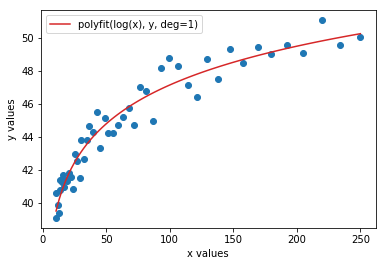

In [7]:
plot_polyfit(coefs, x, y, 'polyfit(log(x), y, deg=1)', np.log)

**Step 2:** Compute the RSS and $R^2$ measures

In [8]:
def RSS(y, y_pred):
    return np.sum(np.square(y - y_pred))


def MSE(y, y_pred):
    return np.mean(np.square(y - y_pred))


def RMSE (y , y_pred ):
    return np.sqrt(MSE(y, y_pred))

In [9]:
y_pred = np.polyval(coefs, np.log(x))
print(f'RSS: {RSS(y, y_pred):.3f} (MSE: {MSE(y, y_pred):.3f}, RMSE: {RMSE(y, y_pred):.3f})')
print(f'R^2 coefficient: {r2_score(y, y_pred):.3f}')

RSS: 31.843 (MSE: 0.637, RMSE: 0.798)
R^2 coefficient: 0.941


**Step 3:** Discuss the results, is it a good $R^2$ score?

**Comment:** Since the $R^2$ score is close to $1$, this means that the model performs much better than the baseline (mean).
(We did not compute the $\mathop{MAE}$ but since $\mathop{MAE} \leq \mathop{RMSE}$, we know that the magnitude of the error of our model is less than or equal to $0.8$ on average.)

## Task 2<a name="task-2"></a> ([top](#top))
---

The second task consists of fitting a model to a set of data points that contains outliers.

Approaches:
* Fit a linear regression with the outliers
* Fit a Huber regression with the outliers
* Fit a linear regression without the outliers

In [10]:
# Standard library:
import collections
import pathlib

# 3rd party:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split

%matplotlib inline

We start by reading the data set:

In [11]:
df2 = pd.read_csv(pathlib.Path.cwd() / 'task-2.csv')

In [12]:
df2.shape

(1000, 4)

In [13]:
df2.head()

,x1,x2,x3,y
0,7.892,318.818,162.970,2112.420
1,8.830,303.180,181.399,2096.231
2,13.811,296.231,145.849,2067.045
3,12.863,325.830,167.996,2269.262
4,13.698,254.035,171.892,1966.604


Preliminaries:

In [14]:
# This will hold the fitted models:
models = collections.OrderedDict()

# We extract the feature matrix and the target vector:
X = df2.drop(columns='y').to_numpy()
y = df2['y'].to_numpy()

We first consider the entire data set (including outliers):

In [15]:
# Split the data into a training set (80 %) and a test set (20 %):
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

We take the median as our baseline:

In [16]:
# Fit a dummy regression:
dummy = DummyRegressor(strategy='median')
dummy.fit(X_tr, y_tr);
models['baseline'] = dummy

We fit the suggested models:

In [17]:
# Fit a linear regression:
linear = LinearRegression()
linear.fit(X_tr, y_tr);
models['lin-regr'] = linear

# Fit a Huber regression:
huber = HuberRegressor(epsilon=1.35)
huber.fit(X_tr, y_tr)
models['huber'] = huber

Before we try to remove outliers, we check the distributions for all features (to make sure that they are not skewed):

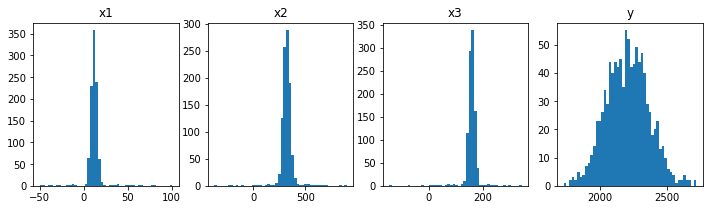

In [18]:
# Plot histograms:
_, ncols = df2.shape
fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols * 3, 3))
for ax, col in zip(axs, df2.columns):
    ax.hist(df2[col], bins=50)
    ax.set_title(col)
plt.show()

We implement a helper function to remove outliers based on a score function (applied to all features as well as to the target variable):

In [19]:
def remove_outliers_and_fit(X_tr, y_tr, score, threshold):
    # We temporarily put X and y back together to simplify things:
    Xy_tr = np.c_[X_tr, y_tr]

    # Compute scores and mask:
    scores = score(Xy_tr)
    le_threshold = np.abs(np.nan_to_num(scores)) <= threshold
    
    # Find non-outliers (i.e. data points with components that are all ≤ threshold):
    mask = le_threshold.all(axis=1)
    X_tr_wo = X_tr[mask]
    y_tr_wo = y_tr[mask]

    # Fit a linear regression:
    linear = LinearRegression()
    linear.fit(X_tr_wo, y_tr_wo)
    
    # This is just an FYI:
    noutliers = (~mask).sum()
    
    return linear, noutliers

We remove outliers using the z-score and then fit a linear regression:

In [20]:
linear, nout = remove_outliers_and_fit(X_tr, y_tr, zscore, 3)
ntot = X_tr.shape[0]
pout = 100.0 * nout / ntot
print(f'outliers: {nout} ({pout:.2f} %), non-outliers: {ntot - nout} ({100 - pout:.2f} %)')
models['lin-regr-wo'] = linear

outliers: 37 (4.62 %), non-outliers: 763 (95.38 %)


Here is a variant of the z-score that I stumbled upon. **Reference:** Boris Iglewicz and David Hoaglin. *How to Detect and Handle Outliers*. ASQC (American Society for Quality Control), 1993. (I have no background in statistics, but the text mentions that the constant $0.6745$ below is needed because $\operatorname{E}[MAD] = 0.6745 \sigma$ for large $n$.) 

In [21]:
def modified_zscore(a):
    median = np.median(a, axis=0)
    mad = np.median(np.abs(a - median), axis=0)  # median absolute deviation
    modified_z_scores = 0.6745 * (a - median) / mad
    return modified_z_scores

We remove outliers using the modified z-score and then fit a linear regression:

In [22]:
linear, nout = remove_outliers_and_fit(X_tr, y_tr, modified_zscore, 3)
ntot = X_tr.shape[0]
pout = 100.0 * nout / ntot
print(f'outliers: {nout} ({pout:.2f} %), non-outliers: {ntot - nout} ({100 - pout:.2f} %)')
models['lin-regr-wo-mod'] = linear

outliers: 45 (5.62 %), non-outliers: 755 (94.38 %)


We compare the different models:

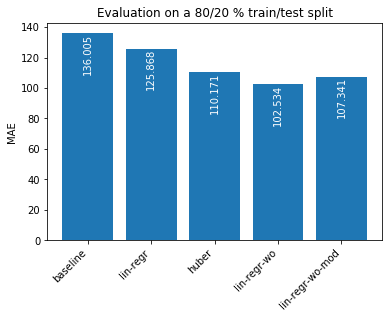

In [23]:
labels = []
mae_values = []
for name, model in models.items():
    labels.append(name)
    # Vector with predictions on test set:
    y_pred = model.predict(X_te)
    # MAE of predictions on test set:
    mae = MAE(y_te, y_pred)
    mae_values.append(mae)


fig, ax = plt.subplots()
xcor = np.arange(len(mae_values))
ax.bar(xcor, mae_values)
ax.set_xticks(xcor)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('MAE')

for i, mae in enumerate(mae_values):
    plt.annotate(f'{mae:.3f}', xy=(i, mae), rotation=90, color="white", ha='center', va='top')

ax.set_title('Evaluation on a 80/20 % train/test split')
plt.show()

**Comment:** The linear regression without outliers and Huber regression all perform better than the linear regression with outliers. (The linear regression without outliers based on the modified z-score performs slightly worse than the one based on the regular z-score but still better than the Huber regression.)